## Problem definition

In [1]:
# ---------------------------------------------------------------------------*/
# - import necessary python packages

import numpy as np
from matplotlib import pyplot as plt

import notebook_utilities as nbutils
tf = nbutils.import_tensorflow()

import utilities as utils
import function as fun

### Dynamical system

In [2]:
# ---------------------------------------------------------------------------*/
# - put prior, analytical, knowledge into code

def osc_true(d: tf.Tensor, w0: tf.Tensor, t: tf.Tensor) -> tf.Tensor:
    """Compute an analytical solution to an under-damped harmonic oscillator problem."""
    assert d < w0
    w = tf.sqrt(w0**2-d**2)
    phi = tf.math.atan(-d/w)
    A = 1/(2*tf.cos(phi))
    cos = tf.cos(phi+w*t)
    exp = tf.exp(-d*t)
    u = exp*2*A*cos
    return u

## Identifying system parameters using a physics-informed neural network

True value of mu: 4.0


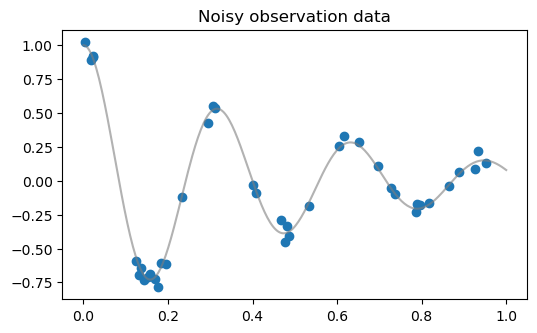

In [3]:
# ---------------------------------------------------------------------------*/
# - configure a harmonic oscillator

d, w0 = tf.constant(2.), tf.constant(20.)
print(f"True value of mu: {2*d}")

# prepare random observation points with some amount of measurement noise
t_obs = tf.random.uniform(shape=[40, 1])
u_obs = osc_true(d, w0, t_obs) + 0.04*tf.random.normal(tf.shape(t_obs))

# time points for testing
t = tf.reshape(tf.linspace(0., 1., 300), shape=(-1, 1))

# true harmonic oscillator response
u_true = osc_true(d, w0, t)

plt.figure(figsize=(6, 3.5))
plt.title("Noisy observation data")
plt.scatter(t_obs[:, 0], u_obs[:, 0])
plt.plot(t[:, 0], u_true[:, 0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

In [4]:
# ---------------------------------------------------------------------------*/
# - neural network for invertion

# preset the random number generator to get reproducible results
utils.preset_rng_tf(123)

# construct a single-input single-output fully-connected neural network with two hidden layers
osc = fun.neuralnetwork(
    arch=[1, 16, 16, 1],
    acts=['tanh', 'tanh', 'linear'])

osc.print()

Model: "fcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

None


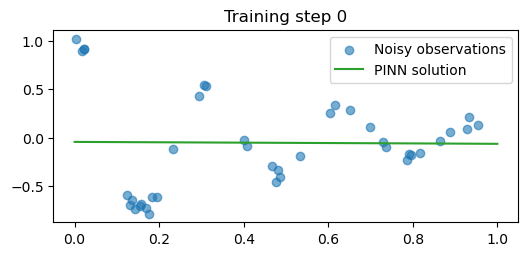

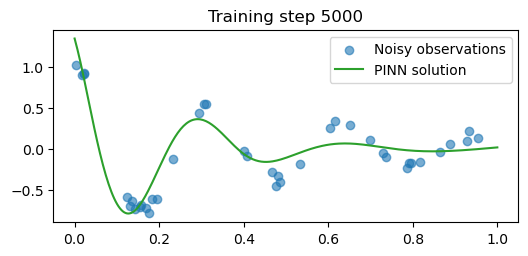

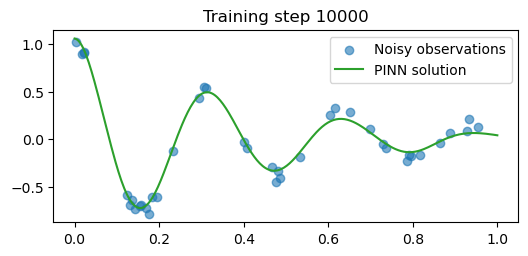

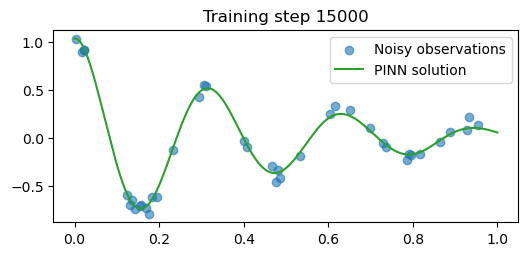

In [5]:
# ---------------------------------------------------------------------------*/
# - train the neural network for parameter identification

_, k = 2*d, w0**2

# time points to check physics
t_phys = tf.reshape(tf.linspace(0., 1., 30), shape=(-1, 1))

hp_data = 1e4

mu = tf.constant(0.)
mu_stats = []

lr = 0.005

# instantiate a stochastic gradient descent optimizer
opt = tf.keras.optimizers.Adam(learning_rate=lr)

# train the neural network using a manual loop
epochs = 15001
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        tape.watch(mu)

        # compute physics loss
        with tf.GradientTape() as tape_phys:
            tape_phys.watch(t_phys)
            with tf.GradientTape() as tape2_phys:
                tape2_phys.watch(t_phys)
                u = osc(t_phys)
            dudt = tape2_phys.gradient(u, t_phys)
        d2udt2 = tape_phys.gradient(dudt, t_phys)
        loss_phys = tf.reduce_mean((d2udt2 + mu*dudt + k*u)**2)

        # compute data loss
        u = osc(t_obs)
        loss_data = tf.reduce_mean((u - u_obs)**2)

        # combine losses together
        loss = loss_phys + hp_data * loss_data

    [params_grad, mu_grad] = tape.gradient(loss, [osc.parameters, mu])
    mu = mu - lr*mu_grad
    opt.apply_gradients(zip(params_grad, osc.parameters))

    # save mu values for later statistics
    mu_stats.append(mu.numpy())

    # plot results as the training progresses
    if epoch % 5000 == 0:
        u = osc(t)
        plt.figure(figsize=(6, 2.5))
        plt.scatter(t_obs[:, 0], u_obs[:, 0], label="Noisy observations", alpha=0.6)
        plt.plot(t[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {epoch}")
        plt.legend()
        plt.show()


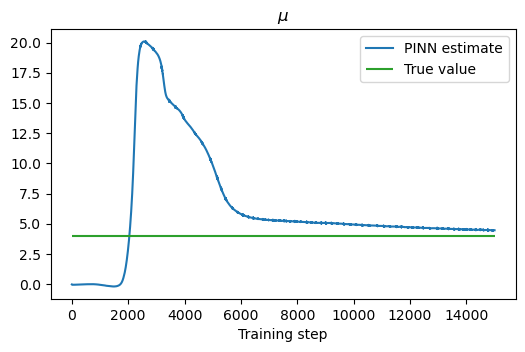

In [6]:
# ---------------------------------------------------------------------------*/
# - check idetified parameters

plt.figure(figsize=(6, 3.5))
plt.title("$\mu$")
plt.plot(mu_stats, label="PINN estimate")
plt.hlines(2*d, 0, len(mu_stats), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()